# An Identiconizer generator implementation in Python

This small notebook implements a generator of small square icons like the ones in GitHub, as [implemented by identicon.js](https://github.com/stewartlord/identicon.js#identiconjs).

## The function

In [1]:
import random
import numpy as np
from matplotlib.colors import hsv_to_rgb
from PIL import Image, ImageDraw

In [2]:
%load_ext watermark
%watermark
%watermark -a "Lilian Besson (Naereen)" -p numpy,matplotlib,PIL

2017-11-25T18:08:42+01:00

CPython 3.6.3
IPython 6.2.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.13.0-17-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Lilian Besson (Naereen) 

numpy 1.13.3
matplotlib 2.1.0
PIL 4.3.0


In [264]:
def identicon(hashval=None,
              size=256,
              margin=0.11,
              foreground=(255,0,0,255),
              background=(240,240,240,255),
              saturation=0.7,
              brightness=0.5,
              xsym=True,
    ):
    if hashval is not None:
        if isinstance(hashval, str):
            hashval = abs(hash(hashval))
        random.seed(int(hashval))

    hue = random.random()
    foreground = tuple(np.array(hsv_to_rgb([hue, saturation, brightness]) * 256, dtype=int)) 

    border = int(size * margin)
    ampl = size - 2 * border
    def cropfirst(x):
        return max(border, min(border + x, size - border))
    def cropsecond(x):
        return max(border, min(size - border - x, size - border))

    # make a blank image
    im = Image.new('RGBA', (size,size), background)    
    # get a drawing context
    d = ImageDraw.Draw(im)

    def rect(xy):
        x1, y1, x2, y2 = xy
        r1 = (cropfirst(x1), cropfirst(y1), cropfirst(x2), cropfirst(y2))
        if xsym:
            r2 = (cropsecond(x1), cropfirst(y1), cropsecond(x2), cropfirst(y2))
        else:
            r2 = (cropfirst(x1), cropsecond(y1), cropfirst(x2), cropsecond(y2))
        d.rectangle(r1, fill=foreground)
        d.rectangle(r2, fill=foreground)

    nbrectangle = random.randint(4, 8)
    for i in range(nbrectangle):
        x1, y1 = [random.randint(0, ampl) for _ in range(2)]
        dx, dy = [random.randint(ampl // 8, ampl // 2) for _ in range(2)]
        dirx, diry = [random.choice([+1, -1]) for _ in range(2)]
        rect((x1, y1, x1 + dirx * dx, y1 + diry * dy))
    return im

In [283]:
im = identicon()

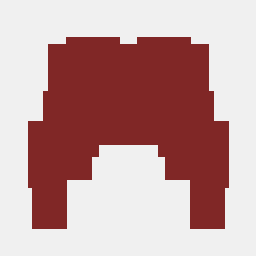

In [284]:
im

## Tests

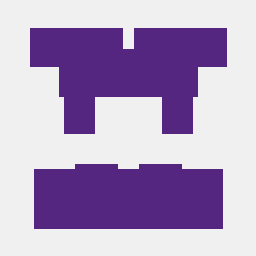

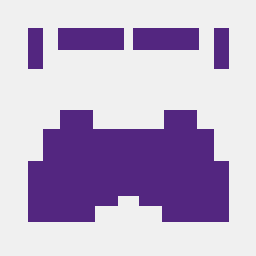

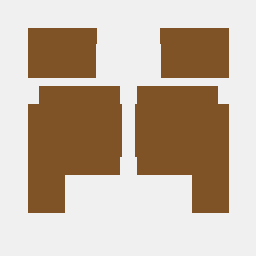

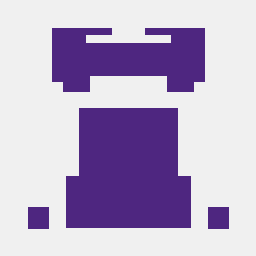

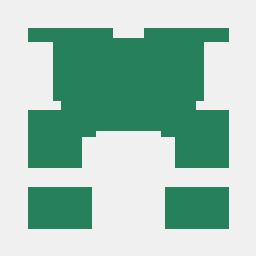

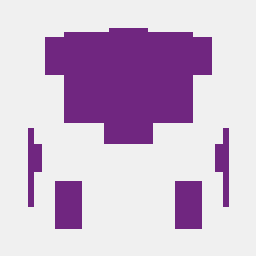

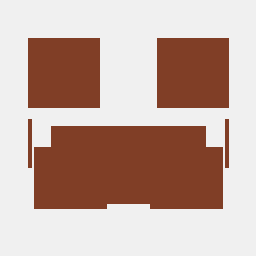

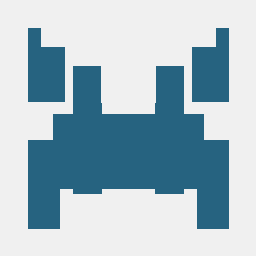

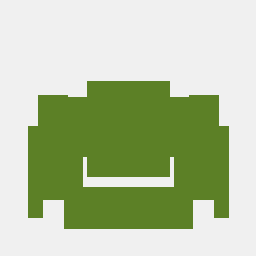

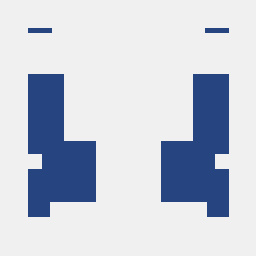

In [270]:
for _ in range(10):
    im = identicon()
    im

## Conclusion

> *That's it for today, folks!* [See on my GitHub for more notebooks](https://github.com/Naereen/notebooks)